*Tutorial based on: https://pyquantnews.com/quickly-compute-value-at-risk-with-monte-carlo/*

In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppresses pandas deprecation warning about future dependence on Pyarrow


import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import time
from openbb import obb

In [2]:
sectors = [
    "XLE",
    "XLF",
    "XLU",
    "XLI",
    "GDX",
    "XLK",
    "XLV", 
    "XLY", 
    "XLP", 
    "XLB", 
    "XOP", 
    "IYR", 
    "XHB", 
    "ITB", 
    "VNQ", 
    "GDXJ", 
    "IYE", 
    "OIH", 
    "XME", 
    "XRT", 
    "SMH", 
    "IBB", 
    "KBE", 
    "KRE", 
    "XTL",]

data = obb.equity.price.historical(
    sectors,
    start_date="2013-01-01",
    provider="yfinance").to_df()

# Aggregating daily returns
data["returns"] = data.groupby("symbol").close.pct_change()
portfolio_stats = data.groupby("symbol").agg(daily_returns=("returns", "mean"))
days = len(data.index.unique())
historical_returns = np.full(
    shape=(days, len(sectors)), 
    fill_value=portfolio_stats.daily_returns)

# Getting the weights for each fund
portfolio_stats["weights"] = 1 / len(sectors)

# Computing the covariance matrix and its decomposition
covariance_matrix = (
    data
    .pivot(
        columns="symbol", 
        values="returns")
    .dropna()
    .cov())
L = np.linalg.cholesky(covariance_matrix)

# Setting simulation parameters
simulations = 100_000
initial_capital = 100_000
alpha = 5

In [3]:
def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)


def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()


def simulate(L, portfolio_stats, historical_returns):
    portfolio = np.zeros((days, simulations))
    for i in range(0, simulations):
        Z = np.random.normal(size=(days, len(sectors)))
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, portfolio_stats.weights) + 1) * initial_capital
        )
    return pd.DataFrame(portfolio)

In [4]:
start = time.time()
simulated_portfolio = simulate(L, portfolio_stats, historical_returns)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 273.1324088573456 seconds ---


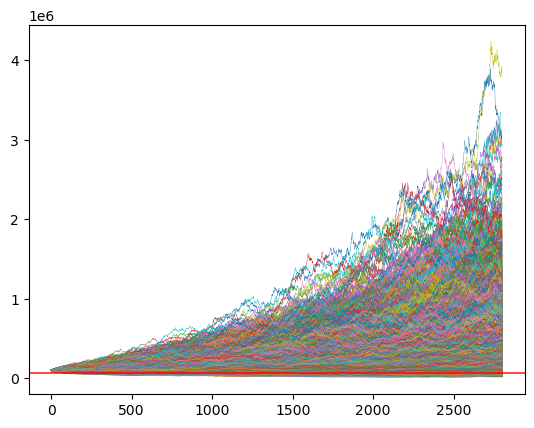

In [5]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()

In [6]:
@nb.jit(parallel=True)
def simulate_with_numba(sectors, L, weights, historical_returns):
    portfolio = np.zeros((days, simulations))
    n_sectors = len(sectors)
    for i in nb.prange(0, simulations):
        Z = np.zeros((days, n_sectors))
        for d in nb.prange(0, days):
            for s in nb.prange(0, n_sectors):
                Z[d, s] = np.random.normal()
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, weights) + 1) * initial_capital
        )
    return portfolio

In [7]:
start = time.time()
simulated_portfolio = simulate_with_numba(sectors, L, portfolio_stats.weights.to_numpy(), historical_returns)
simulated_portfolio = pd.DataFrame(simulated_portfolio)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 79.7617871761322 seconds ---


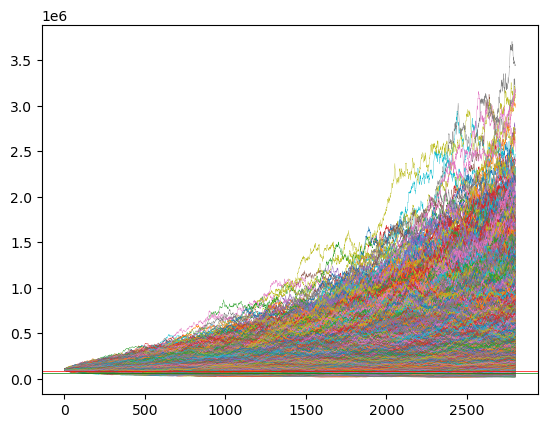

In [8]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()

In [9]:
@nb.njit(parallel=True)
def simulate_with_numba_compiled(sectors, L, weights, historical_returns):
    portfolio = np.zeros((days, simulations))
    n_sectors = len(sectors)
    for i in nb.prange(0, simulations):
        Z = np.zeros((days, n_sectors))
        for d in nb.prange(0, days):
            for s in nb.prange(0, n_sectors):
                Z[d, s] = np.random.normal()
        daily_returns = historical_returns + np.dot(L, Z.T).T
        portfolio[:, i] = (
            np.cumprod(np.dot(daily_returns, weights) + 1) * initial_capital
        )
    return portfolio

In [10]:
start = time.time()
simulated_portfolio = simulate_with_numba_compiled(sectors, L, portfolio_stats.weights.to_numpy(), historical_returns)
simulated_portfolio = pd.DataFrame(simulated_portfolio)
end = time.time()
print("--- %s seconds ---" % (end - start))

--- 66.63325572013855 seconds ---


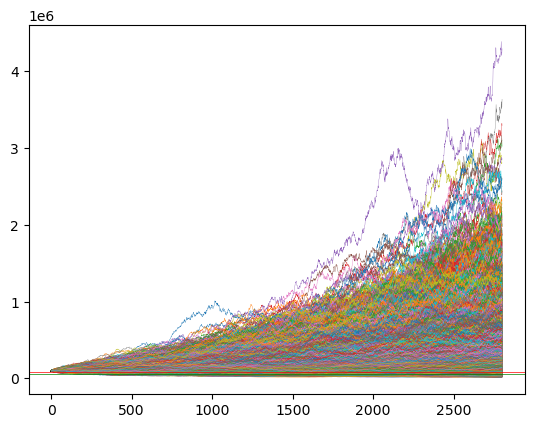

In [11]:
mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
plt.show()